In [21]:
import csv
import numpy as np
import keras
import os
from scipy.misc import imread
import keras.backend as K
import tensorflow as tf
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.models import Model
from DataGenerator import DataGenerator
from keras.utils import multi_gpu_model

test_dir = 'TestDataset'
num_classes = 14951

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
data_dir = 'ReducedTrainDatasets/Train0'
label_to_class = {}
for i, class_dir in enumerate(os.listdir(data_dir)):
    label_to_class[i] = int(class_dir)

In [29]:
def declare_model(reg=0):
    resnet = keras.applications.resnet50.ResNet50(include_top=False,
     weights="imagenet",
     input_shape=(224,224,3),
     pooling=None)
    # We will train the last 12 layers of ResNET and leave the others unchanged
    for layer in resnet.layers[:-8]:
        layer.trainable = False

    x = resnet.output
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    #x = Dense(num_classes, activation='relu', kernel_regularizer=regularizers.l2(reg))(x)
    scores = Dense(8763, activation='softmax', kernel_regularizer=regularizers.l2(reg))(x)

    return Model(inputs=resnet.inputs, outputs=scores)

In [30]:
K.clear_session()
model = declare_model(reg=0)
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom=True)
adam = keras.optimizers.Adam(lr=5e-4)
#parallel_model = multi_gpu_model(model, gpus=2)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'], options=run_opts)
model.load_weights('models/train0_reduced_weights.h5')

In [31]:
def load_im_list(test_dir):
    ims = []
    keys = []
    for im in os.listdir(test_dir):
        img = os.path.join(test_dir, im)
        ims.append(img)
        keys.append(im[:-4])
    return ims, keys

In [32]:
ims, keys = load_im_list(test_dir)
test_generator = DataGenerator(ims, None, 1, n_classes=num_classes, batch_size=64, shuffle=False)
preds = model.predict_generator(test_generator, use_multiprocessing=True, workers=6)
print(preds.shape)
print(preds[0])

labels = np.argmax(preds, axis=1)
confidence = preds[range(preds.shape[0]), labels]

d = {}
with open('CSV-files/test.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        d[row['id']] = '0 0.00'

for k, l, c in zip(keys, labels, confidence):
    d[k] = '{} {:0.2f}'.format(label_to_class[l], c)
    
with open('CSV-files/submission_reduced2.csv', 'w') as f:
    fieldnames = ['id', 'landmarks']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for k, v in d.items():
        writer.writerow({'id':k, 'landmarks': v})





(115264, 8763)
[2.8637714e-10 1.2810162e-11 4.9347814e-13 ... 2.3993360e-08 3.9018483e-10
 4.0821605e-13]


In [9]:
label_to_class[4707]

6051

In [20]:
np.save('preds/preds_train0.npy', preds)

In [8]:
np.argmax(preds, axis=1)[:100]

array([ 4443, 11955, 14426, 14679, 11472,  4860,  4011,  9434,  3943,
        5987, 10634, 12125,  4011,  3096, 13780, 10649, 10940, 12218,
         428,  4011, 14426,  2810,  7746,  4011,  2806, 12658, 13256,
       11452,  4528, 11394,  7673, 13827,   428,  7070,  2495, 11998,
        1553,  7058, 12965, 14748,  1157,  9927,  2717,  3965,  5010,
        9841, 13749, 14037, 11054,   304, 12218,  8167, 10688,  9657,
        9618,  2717,   428, 13171,  9135, 11362,  8726,  5778,  4562,
       13883,  6957,  1296, 11580,   428,  6442,   428,   189, 14753,
       13827,  1296,  3096,  2196,  3090,   511, 13611,  1915,  2424,
        8726,  4034,  1749,   304,  2761,  9740,  1553,  4523,  2940,
         428,  4436, 13875,  5929,  2885, 14797,  4682, 13875,  1042,
        7774])

In [9]:
labels = np.argmax(preds, axis=1)
confidence = preds[range(preds.shape[0]),labels]
print(np.mean(confidence))

0.41733626


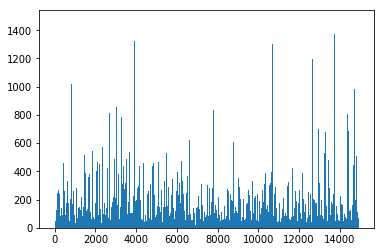

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(labels, bins=500)
plt.show()

In [13]:
labels[0]

4443

In [14]:
keys[0]

'8970f4e3ecc4d6b6'

In [17]:
preds[0][4443]

0.9929737